# _Drosophila melanogaster_ male courtship song

Requires _DAS_ to be installed. See [documentation](https://janclemenslab.org/das/installation.html) for instructions.

Sample data from:   
Stern DL. 2014.   
Reported Drosophila courtship song rhythms are artifacts of data analysis.   
BMC Biology 12:38.   
Original data deposited at [https://www.janelia.org/lab/stern-lab/tools-reagents-data]().

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import librosa.feature, librosa.display
import das.predict, das.evaluate, das.utils_plot, das.menagerie
from pprint import pprint

plt.style.use('../ncb.mplstyle')

## Download data from the repository
Release [https://github.com/janclemenslab/das-menagerie/releases/Dmel_single_v1.0/]()

`data.npz` contains the following variables
- `x`: the audio data `[nb_samples, nb_channels]
- `samplerate_Hz`: audio sample rate in Hz
- `y_true`: groundtruth annotations `[nb_samples, nb_classes]`
- `class_names`: class names `[nb_classes,]`

dict_keys(['x', 'y_true', 'samplerate_Hz', 'class_names'])


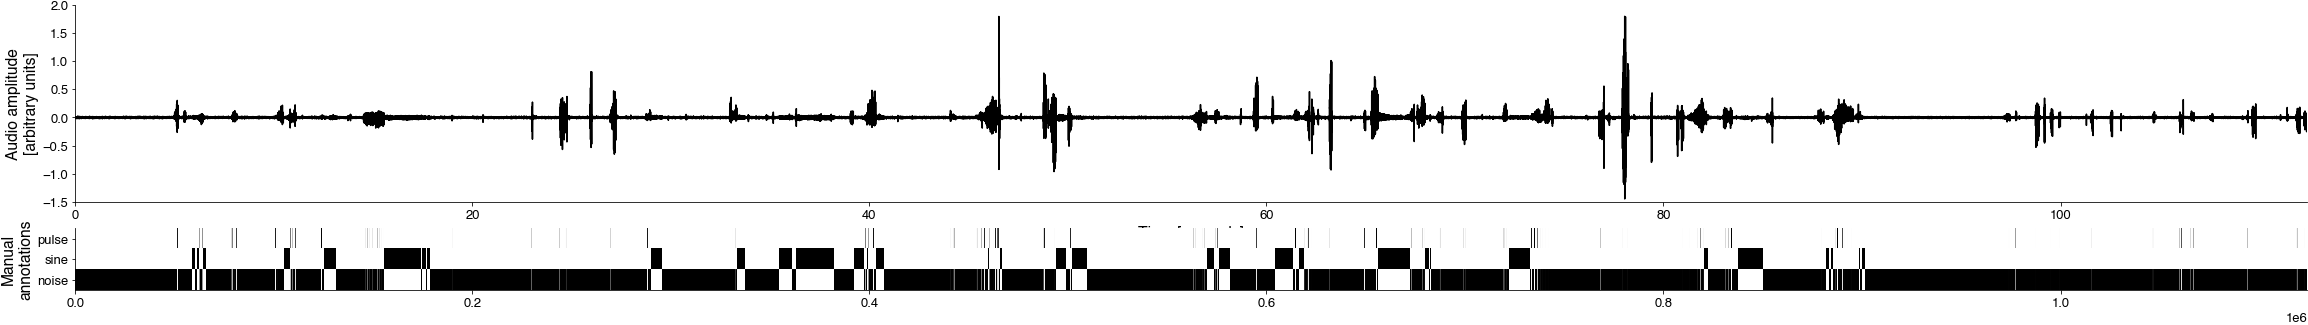

In [2]:
url = "https://github.com/janclemenslab/das-menagerie/releases/download/Dmel_single_v1.0/data.npz"
data = das.menagerie.load_data(url)
print(data.keys())

samplerate_Hz = data['samplerate_Hz']
T = np.arange(len(data['x'])) / samplerate_Hz

plt.figure(figsize=(40, 8))
plt.subplot(211)
plt.plot(T, data['x'], c='k')
plt.xlim(T[0], T[-1])
plt.xlabel('Time [seconds]')
plt.ylabel('Audio amplitude\n[arbitrary units]')

plt.subplot(614)
plt.imshow(data['y_true'].T, cmap='Greys')
plt.yticks(np.arange(len(data['class_names'])), labels=data['class_names'])
plt.ylabel('Manual\nannotations')

plt.show()

## Generate annotations using _DAS_
Using `das.predict`

Returns:
- `events`: Blah. Important keys: 
- `segments`: Blah. Important keys: 
- `class_probabilities`: 
- `class_names`:

In [3]:
model_path = 'https://github.com/janclemenslab/das-menagerie/releases/download/Dmel_single_v1.0/pulse+sine'
events, segments, class_probabilities, class_names = das.predict.predict(data['x'], model_path, event_thres=0.7, event_dist=0.01, segment_minlen=0.02, segment_fillgap=0.02)

/Users/clemens10/miniconda3/lib/python3.7/site-packages/tensorflow/python/keras/layers/core.py:1061: UserWarning: dss.tcn.tcn is not loaded, but a Lambda layer uses it. It may cause errors.
  , UserWarning)
/Users/clemens10/miniconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:2426: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


## Plot _DAS_ and manual annotations

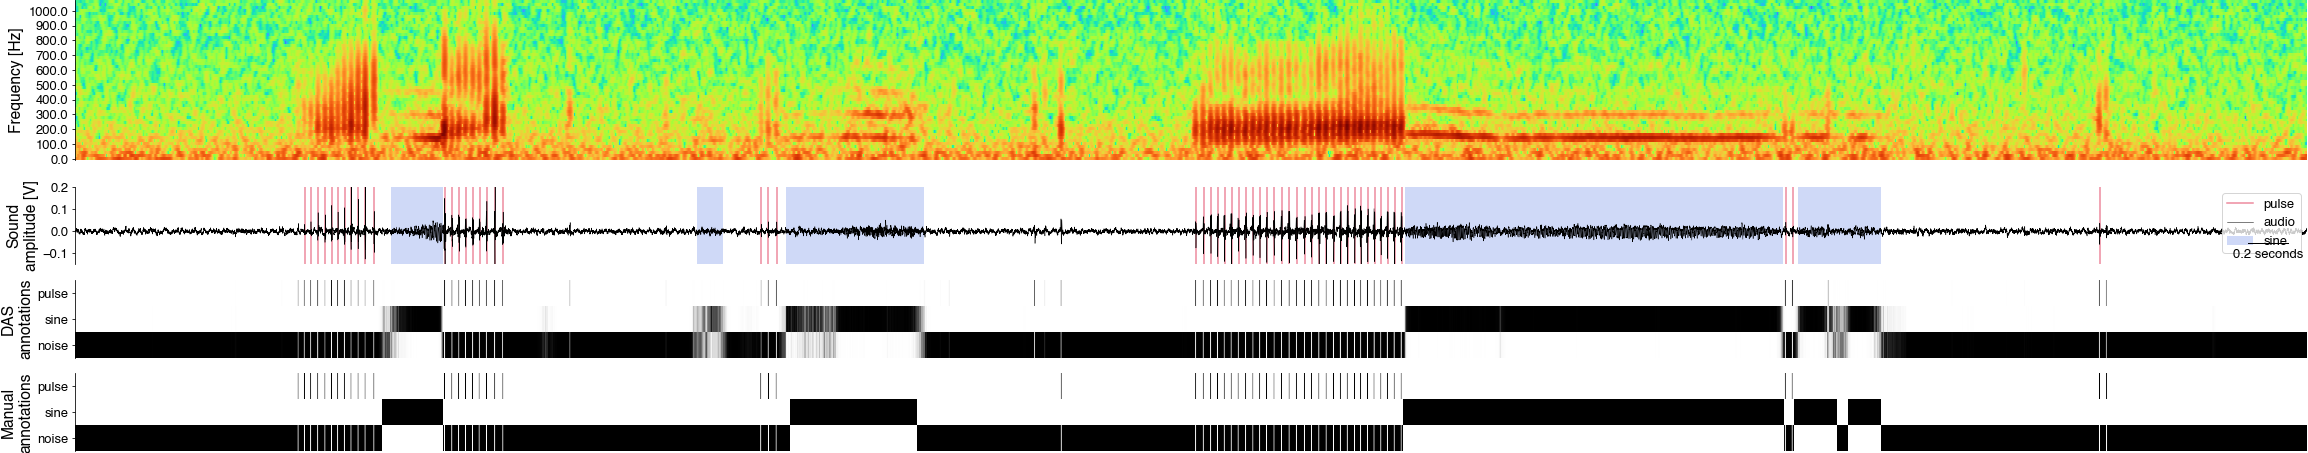

In [29]:
i0, i1 = int(0.9e5), int(2e5)
T = np.arange(i0, i1) / samplerate_Hz

specgram = librosa.feature.melspectrogram(data['x'][i0:i1,0], sr=samplerate_Hz, n_fft=512, hop_length=16, power=1)
specgram = librosa.amplitude_to_db(specgram, ref=np.max(specgram))
freqs = np.round(librosa.mel_frequencies(n_mels=specgram.shape[0], fmin=0.0, fmax=samplerate_Hz / 2, htk=False)/10) * 10

freqs = freqs[freqs<1_100]
freq_ticks = np.where(np.mod(freqs, 100)<=10)[0]
freq_labels, idx = np.unique(np.round(freqs[freq_ticks]/100)*100, return_index=True)
freq_ticks = freq_ticks[idx]

plt.figure(figsize=(40, 10))
plt.subplot(311)
plt.imshow(specgram[:len(freqs), :], cmap='turbo')
plt.yticks(freq_ticks, labels=freq_labels)
plt.ylabel('Frequency [Hz]')
das.utils_plot.despine(which='tbr')

plt.subplot(613)
das.utils_plot.annotate_events(event_seconds=events['seconds'], event_names=events['sequence'], tmin=T[0], tmax=T[-1], color='crimson')
das.utils_plot.annotate_segments(onset_seconds=segments['onsets_seconds'], offset_seconds=segments['offsets_seconds'], segment_names=segments['sequence'], tmin=T[0], tmax=T[-1], color='royalblue')
plt.plot(T, data['x'][i0:i1], c='k', linewidth=0.5, label='audio')
plt.xlim(T[0], T[-1])
plt.ylim(-0.15, 0.2)
plt.yticks(np.arange(-0.1, 0.2, 0.1))
plt.legend(loc='upper right', frameon=True, facecolor='w')
plt.ylabel('Sound\namplitude [V]')
das.utils_plot.despine(which='tbr')
das.utils_plot.scalebar(length=0.2, units='seconds')

plt.subplot(614)
plt.imshow(class_probabilities[i0:i1, :].T, cmap='Greys')
plt.yticks(np.arange(len(class_names)), labels=class_names)
plt.ylabel('DAS\nannotations')
das.utils_plot.despine(which='tbr')

plt.subplot(615)
plt.imshow(data['y_true'][i0:i1].T, cmap='Greys')
plt.yticks(np.arange(len(class_names)), labels=class_names)
plt.ylabel('Manual\nannotations')
das.utils_plot.despine(which='tbr')
plt.show()

## Evaluate performance for sine

In [5]:
min_len = min(data['y_true'].shape[0], class_probabilities.shape[0])
confmat_sine, report_sine = das.evaluate.evaluate_segments(data['y_true'][:min_len, 1], segments['samples'][:min_len]==1, ['noise','sine'], confmat_as_pandas=True, report_as_dict=False)
print('Confusion matrix')
print(confmat_sine)
print('Classification report')
print(report_sine)

Confusion matrix
            true noise  true sine
pred noise      948653      12221
pred sine         4055     159423
Classification report
              precision    recall  f1-score   support

       noise      0.996     0.987     0.991    960874
        sine      0.929     0.975     0.951    163478

    accuracy                          0.986   1124352
   macro avg      0.962     0.981     0.971   1124352
weighted avg      0.986     0.986     0.986   1124352



## Evaluate performance for pulse

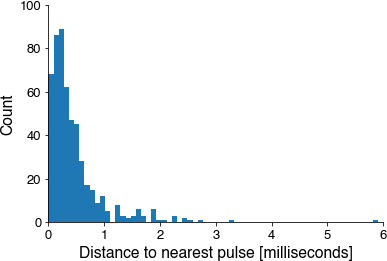

{'FN': 31,
 'FP': 17,
 'TP': 525,
 'f1_score': 0.9562841530054644,
 'precision': 0.9686346863468634,
 'recall': 0.9442446043165468}


In [6]:
# evaluate performance for pulse
tol = 0.01 # s
pulsetimes_true, _ = das.event_utils.detect_events(data['y_true'][:min_len, 2], thres=0.5, min_dist=0.01 * samplerate_Hz)
pulsetimes_true = pulsetimes_true / samplerate_Hz
pulsetimes_das = events['seconds']
report_pulse, _, _, dist_to_nearest_pulse = das.event_utils.evaluate_eventtimes(pulsetimes_true, pulsetimes_das, samplerate=samplerate_Hz, tol=tol)
plt.hist(dist_to_nearest_pulse[dist_to_nearest_pulse<tol] * 1000, bins=64)
plt.xlabel('Distance to nearest pulse [milliseconds]')
plt.ylabel('Count')
plt.show()

pprint(report_pulse)